In [1]:
import fastf1 as f1
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Formula 1 Performance Analysis Proposal
## Introduction
In order to perform well in a Formula 1 Grand Prix race, teams must develop a successful strategy for determining what compounds of tires to use during the race (there are several types of tires, each of which have a different tradeoff in terms of grip and lifespan), and when to make a pit stop to swap to a new pair of tires. While this is a very complex problem involving many variables, one of the most important things to consider is how long a set of tires will last before they lose enough grip to justify making a pit stop and changing the tires. One of the simpleset ways to measure vehicle performance is by using the lap times the car is capable of.


This project aims to model vehicle lap times around a circuit, using publicly available features such as:
* Number of laps driven during the session
* Tire age in laps driven
* Number of laps driven at a slower pace (eg, slowdown required for safety reasons)
* Weather data (eg, track and air temperatures, humidity, pressure)
* Distance to car ahead (which impacts the vehicle's aerodynamics)
* Driver's best lap time
* Whether the car has made a pit stop on this lap


For the sake of scope, this project will focus on only one event: the 2025 Japanese Grand Prix, which I have chosen because of its lack of rain and race interuptions in order to make data cleaning and analysis simpler. In the future, the techniques applied here could be used on other events, and with the right features, a model could accurately predict lap times from multiple circuits.

If this project is sufficiently successful, the results could be used for predictive analytics and could assist the development of a "virtual race engineer," or a machine learning model that can make real time decisions in regards to actions such as pit stops in order to complete a race as quickly as possible. Additionally, understanding how different tire compounds perform on a given race track can improve future decisions on which tire types to use in future Grand Prix events.
## Approach
I intend to approach this problem by training a linear model to predict lap times with the specified features. Due to the complex nature of the relationships between some of these attributes, I also intend to use data visualization to determine how and if to transform these features in order to better fit a linear model. Since the scope of this project is explanatory analytics, I will randomly split the entire set of lap data into training and testing data. Further investigation could use free practice data and data from previous events to train a model to predict the outcome of a future race, but we will avoid doing so in this project to maintain a reasonable scope.

I also currently plan on developing a model during 2 phases: the first phase will involve developing a model that uses a minimal number of features, and the second phase will focus on introducing more features to the model. I intend on using this approach mostly as a learning opportunity to gain insight regarding complications and drawbacks of an increasingly complex model.

## Data Source
The best source I found for this project is FastF1, a python package/data warehouse that curates data from Formula 1 official live timings (I came across this framework when I was browsing F1 related data sets on kaggle and saw FastF1 as a source for some of them). Each track session is separated into its own session object, which can be retrieved individually via the FastF1 package:

In [2]:
session = f1.get_session(2025, 3, "R")  # For example, this snippet loads the race from the third Grand Prix of the 2025 season
session.load(telemetry = True, weather = True)

req         WARNING 	DEFAULT CACHE ENABLED! (510.87 MB) /home/studio-lab-user/.cache/fastf1
core           INFO 	Loading data for Japanese Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '4', '81', '16', '63', '12', '44', '6', '23', '87', '14', '22', '10', '55', '7',

Each session object most notably comprises of a table consisting of information pertaining to each lap and collected weather data. There is also car telemetry data, but there is not a single data frame consisting of all telemetry data. To compile all the desired data, we can use the laps table as a base table, then join weather and telemetry data by matching session time. <br>
Each laps data frame also only covers one session, whereas during a Grand Prix there are 5 sessions. Consequently to maximize our data domain, we will have to combine these 5 data frames.

## Lap Data

In [3]:
session.laps.columns

Index(['Time', 'Driver', 'DriverNumber', 'LapTime', 'LapNumber', 'Stint',
       'PitOutTime', 'PitInTime', 'Sector1Time', 'Sector2Time', 'Sector3Time',
       'Sector1SessionTime', 'Sector2SessionTime', 'Sector3SessionTime',
       'SpeedI1', 'SpeedI2', 'SpeedFL', 'SpeedST', 'IsPersonalBest',
       'Compound', 'TyreLife', 'FreshTyre', 'Team', 'LapStartTime',
       'LapStartDate', 'TrackStatus', 'Position', 'Deleted', 'DeletedReason',
       'FastF1Generated', 'IsAccurate'],
      dtype='object')

One important caveat of this data is that the dry compounds are categorized as Soft, Medium, or Hard. In reality, there are currently 6 dry compounds (designated C1 through C6, hardest to softest), and three of these compounds are made available for each Grand Prix. Consequently if we want to compare data between different events, we will need to transform the soft/medium/hard values into their actual compounds. The information necessary to do this is not available in FastF1 but is published by Formula 1. (This is a note for future investigation, we will not need to do this for the scope of this project)

In [4]:
session.laps.head(1)

,Time,Driver,DriverNumber,LapTime,LapNumber,Stint,PitOutTime,PitInTime,Sector1Time,Sector2Time,...,FreshTyre,Team,LapStartTime,LapStartDate,TrackStatus,Position,Deleted,DeletedReason,FastF1Generated,IsAccurate
0,0 days 00:57:41.632000,VER,1,0 days 00:01:34.725000,1.0,1.0,NaT,NaT,NaT,0 days 00:00:41.962000,...,True,Red Bull Racing,0 days 00:56:06.651000,2025-04-06 05:03:47.081,1,1.0,False,,False,False


In [5]:
# Todo: count of FastF1Generated, IsAccurate, Deleted, missing values
print(len(session.laps))
session.laps.isna().sum()[session.laps.isna().sum() > 0]

1059


PitOutTime            1038
PitInTime             1038
Sector1Time             20
Sector1SessionTime      26
SpeedI1                250
SpeedFL                 21
dtype: int64

The missing PitOut/PitInTimes and SpeedFL times make sense considering that each lap should only have one or the other, and the number of missing values between these 2 categories add up to the total number of laps. I am not sure why there are missing values for the other attributes, which means the data is likely incomplete here. <br>
The laps frame is verified to be complete as well (race length of 53 laps times 20 drivers makes for a total of 1060 laps, and one driver was lapped during the race, meaning he has 1 less lap total)

In [6]:
session.laps["FastF1Generated"].value_counts()  # For any actual training/testing, FastF1Generated data will not be used

FastF1Generated
False    1059
Name: count, dtype: int64

In [7]:
session.laps["IsAccurate"].value_counts()

IsAccurate
True     997
False     62
Name: count, dtype: int64

IsAccurate merely refers to lap start times, lap end times, and lap times being consistent, whereas a LapTime is accurate if it exists. Therefore as long as we don't use lap start and end times, this variable shouldn't matter

In [8]:
session.laps["Deleted"].value_counts()  # Deleted laps as far as I'm aware only happen when exceeding track limits. TODO: figure out whether to disregard deleted laps or to differentiate them from other laps in modeling

Deleted
False    1051
True        8
Name: count, dtype: int64

In [9]:
session.laps["DeletedReason"].value_counts()

DeletedReason
                                   1051
TRACK LIMITS AT TURN 17 LAP 53        2
TRACK LIMITS AT TURN 17 LAP 33        1
TRACK LIMITS AT TURN 17 LAP 2         1
TRACK LIMITS AT TURN 17 LAP 47        1
TRACK LIMITS AT TURN 17 LAP 26        1
TRACK LIMITS AT TURN 17 LAP 15        1
TRACK LIMITS AT TURN 17 LAP 25        1
Name: count, dtype: int64

In [10]:
session.laps["TrackStatus"].value_counts()  # We will have to label laps with track status != 1 differently, as drivers will most likely not be driving quickly on those laps

TrackStatus
1    1059
Name: count, dtype: int64

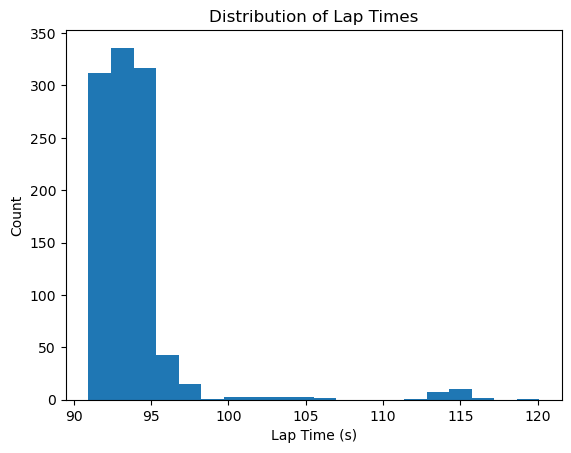

In [11]:
plt.hist(session.laps["LapTime"].dt.total_seconds(), bins = 20)
plt.ylabel("Count")
plt.xlabel("Lap Time (s)")
plt.title("Distribution of Lap Times")
plt.show()

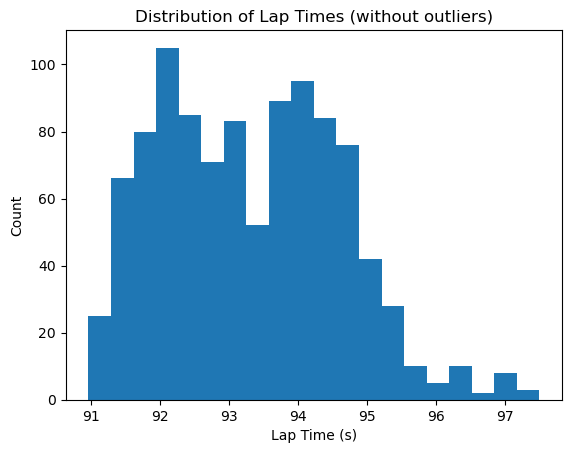

In [12]:
plt.hist(session.laps["LapTime"].dt.total_seconds(), bins = 20, range = (session.laps["LapTime"].dt.total_seconds().min(), 97.5))
plt.ylabel("Count")
plt.xlabel("Lap Time (s)")
plt.title("Distribution of Lap Times (without outliers)")
plt.show()

In [13]:
session.laps[session.laps["LapTime"].dt.total_seconds() > 100]  # All of these laps are either after a pit stop or first lap (from standing start)

,Time,Driver,DriverNumber,LapTime,LapNumber,Stint,PitOutTime,PitInTime,Sector1Time,Sector2Time,...,FreshTyre,Team,LapStartTime,LapStartDate,TrackStatus,Position,Deleted,DeletedReason,FastF1Generated,IsAccurate
21,0 days 01:30:48.101000,VER,1,0 days 00:01:54.078000,22.0,2.0,0 days 01:29:17.340000,NaT,0 days 00:00:54.295000,0 days 00:00:41.802000,...,True,Red Bull Racing,0 days 01:28:54.023000,2025-04-06 05:36:34.453,1,5.0,False,,False,False
74,0 days 01:30:50.149000,NOR,4,0 days 00:01:54.797000,22.0,2.0,0 days 01:29:17.403000,NaT,0 days 00:00:54.865000,0 days 00:00:41.955000,...,True,McLaren,0 days 01:28:55.352000,2025-04-06 05:36:35.782,1,6.0,False,,False,False
126,0 days 01:29:18.113000,PIA,81,0 days 00:01:53.035000,21.0,2.0,0 days 01:27:46.796000,NaT,0 days 00:00:53.115000,0 days 00:00:41.802000,...,True,McLaren,0 days 01:27:25.078000,2025-04-06 05:35:05.508,1,9.0,False,,False,False
180,0 days 01:30:55.162000,LEC,16,0 days 00:01:53.611000,22.0,2.0,0 days 01:29:23.559000,NaT,0 days 00:00:54.102000,0 days 00:00:41.743000,...,True,Ferrari,0 days 01:29:01.551000,2025-04-06 05:36:41.981,1,10.0,False,,False,False
231,0 days 01:27:49.714000,RUS,63,0 days 00:01:52.912000,20.0,2.0,0 days 01:26:18.644000,NaT,0 days 00:00:53.463000,0 days 00:00:41.515000,...,True,Mercedes,0 days 01:25:56.802000,2025-04-06 05:33:37.232,1,13.0,False,,False,False
296,0 days 01:46:33.264000,ANT,12,0 days 00:01:55.527000,32.0,2.0,0 days 01:45:00.814000,NaT,0 days 00:00:55.864000,0 days 00:00:41.899000,...,True,Mercedes,0 days 01:44:37.737000,2025-04-06 05:52:18.167,1,6.0,False,,False,False
318,0 days 00:57:47.186000,HAM,44,0 days 00:01:40.279000,1.0,1.0,NaT,NaT,NaT,0 days 00:00:43.278000,...,True,Ferrari,0 days 00:56:06.651000,2025-04-06 05:03:47.081,1,8.0,False,,False,False
348,0 days 01:45:02.180000,HAM,44,0 days 00:01:52.362000,31.0,2.0,0 days 01:43:31.485000,NaT,0 days 00:00:52.756000,0 days 00:00:41.789000,...,True,Ferrari,0 days 01:43:09.818000,2025-04-06 05:50:50.248,1,7.0,False,,False,False
396,0 days 01:37:22.794000,HAD,6,0 days 00:01:55.586000,26.0,2.0,0 days 01:35:49.203000,NaT,0 days 00:00:55.181000,0 days 00:00:42.396000,...,True,Racing Bulls,0 days 01:35:27.208000,2025-04-06 05:43:07.638,1,10.0,False,,False,False
424,0 days 00:57:47.693000,ALB,23,0 days 00:01:40.786000,1.0,1.0,NaT,NaT,NaT,0 days 00:00:43.689000,...,True,Williams,0 days 00:56:06.651000,2025-04-06 05:03:47.081,1,9.0,False,,False,False


Summarily, the lap data from this source seems to be complete and reasonably accurate.

In [14]:
# Todo: graphs of lap time as function of compound, tire age
def compound_to_color(compound):
    color_dictionary = {"HARD" : "black", "MEDIUM" : "yellow", "SOFT" : "red"}
    return color_dictionary[compound]

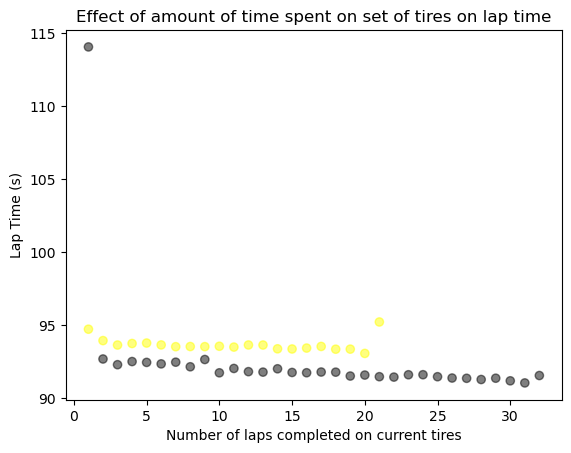

In [15]:
# Medium was first stint
subset = session.laps[session.laps["Driver"] == "VER"]
plt.scatter(subset["TyreLife"], subset["LapTime"].dt.total_seconds(), c = subset["Compound"].apply(compound_to_color), alpha = 0.5)
plt.title("Effect of amount of time spent on set of tires on lap time")
plt.xlabel("Number of laps completed on current tires")
plt.ylabel("Lap Time (s)")
plt.show()

From this graph, it looks like lap times typically decrease as time passes (with outliers corresponding with entering/exiting the pit lane). What is interesting is that the lap times on the hard tire are faster than those on the medium tire, despite the medium tire having more grip, which usually leads to faster lap times as the car can drive through corners more quickly.

## Weather Data

In [16]:
session.weather_data.head()

,Time,AirTemp,Humidity,Pressure,Rainfall,TrackTemp,WindDirection,WindSpeed
0,0 days 00:00:25.703000,14.6,76.0,1009.9,False,22.5,324,1.1
1,0 days 00:01:25.704000,14.5,75.0,1009.9,False,22.6,121,0.4
2,0 days 00:02:25.688000,14.4,75.0,1009.9,False,22.8,132,1.5
3,0 days 00:03:25.704000,14.5,76.0,1010.0,False,23.0,136,0.6
4,0 days 00:04:25.705000,14.6,74.0,1009.9,False,22.9,152,0.9


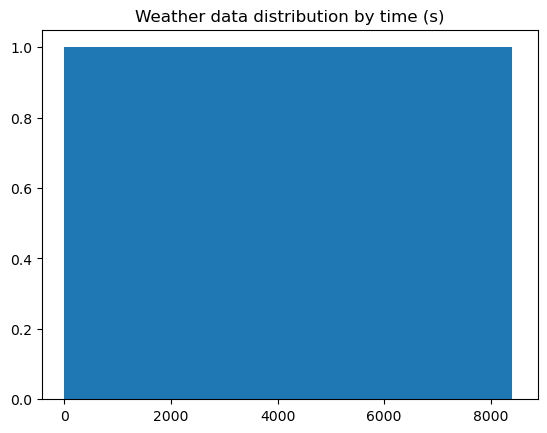

In [17]:
plt.hist(session.weather_data.Time.dt.total_seconds(), bins = range(0, 8500, 60))
plt.title("Weather data distribution by time (s)")
plt.show()

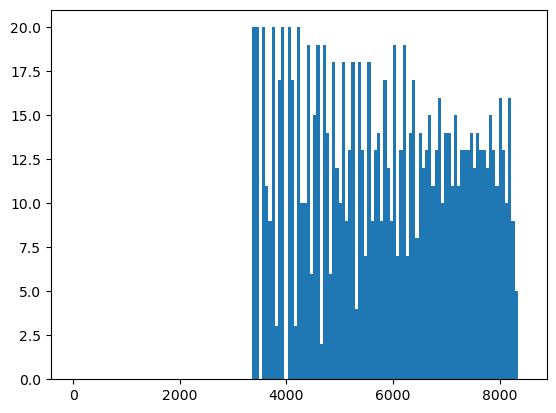

In [34]:
plt.hist(session.laps.LapStartTime.dt.total_seconds(), bins = range(0, 8500, 60))
plt.show()

This histogram implies that weather data is always every ~60 seconds, but we must also consider that this time attribute is out of sync with the session time used by the other tables and will have to convert it.
Update: I since compared the session times of the laps, and the session times are actually in sync.

In [18]:
session.weather_data.isna().sum()#[session.weather_data.isna().sum() > 0]

Time             0
AirTemp          0
Humidity         0
Pressure         0
Rainfall         0
TrackTemp        0
WindDirection    0
WindSpeed        0
dtype: int64

In [19]:
session.weather_data.Rainfall.value_counts()

Rainfall
False    140
Name: count, dtype: int64

<Axes: xlabel='AirTemp', ylabel='Count'>

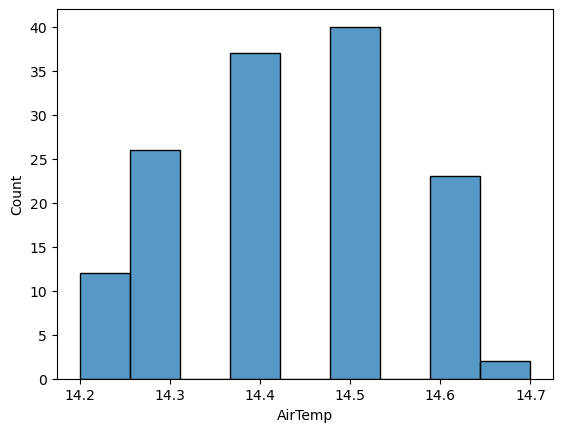

In [20]:
sns.histplot(session.weather_data, x = "AirTemp")

<Axes: xlabel='TrackTemp', ylabel='Count'>

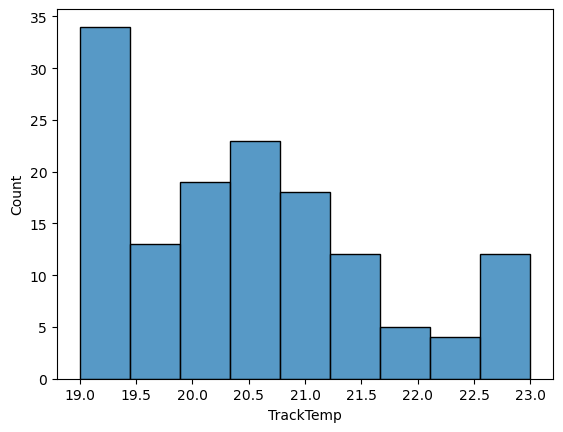

In [21]:
sns.histplot(session.weather_data, x = "TrackTemp")

<Axes: xlabel='Humidity', ylabel='Count'>

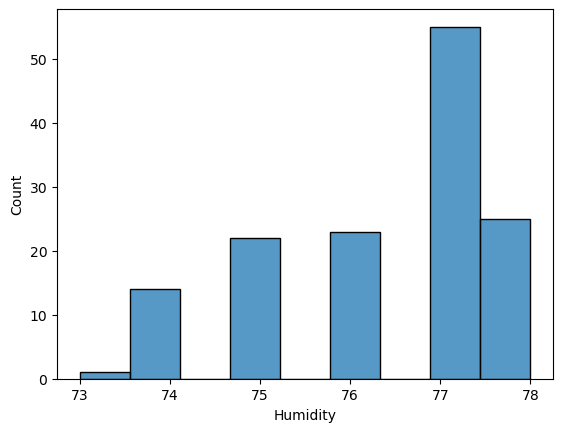

In [22]:
sns.histplot(session.weather_data, x = "Humidity")

<Axes: xlabel='Pressure', ylabel='Count'>

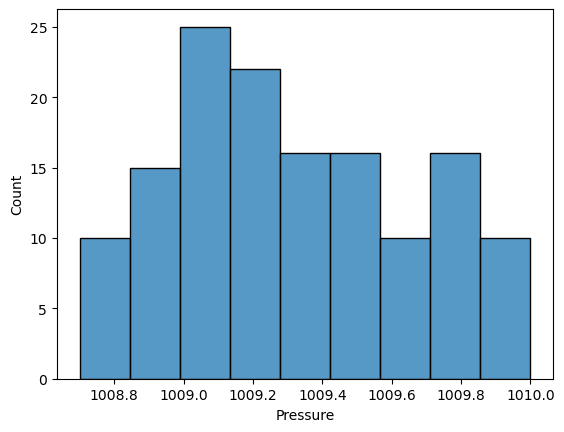

In [23]:
sns.histplot(session.weather_data, x = "Pressure")

<Axes: xlabel='TrackTemp', ylabel='AirTemp'>

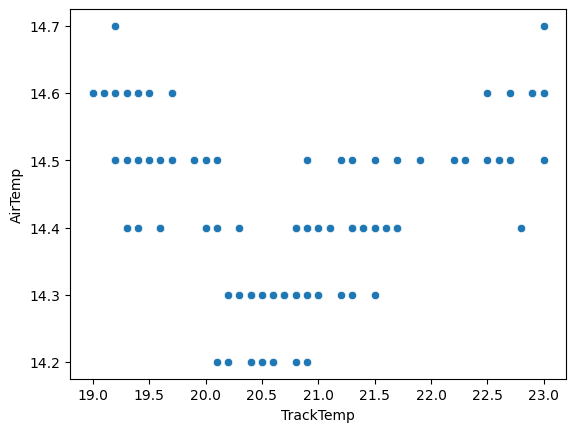

In [24]:
sns.scatterplot(session.weather_data, x = "TrackTemp", y = "AirTemp")  # Looks quadratic? It is likely that this pattern does not hold on a larger data domain

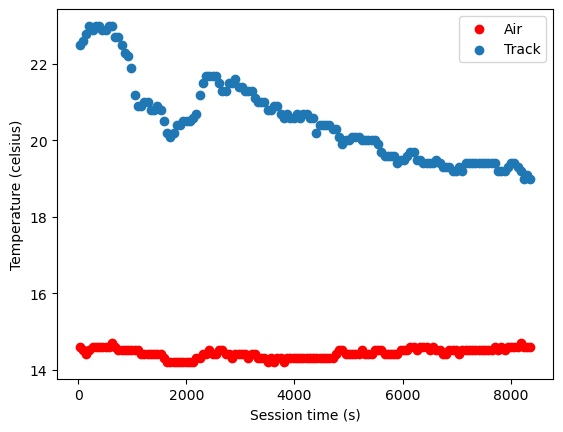

In [25]:
plt.scatter(session.weather_data.Time.dt.total_seconds(), session.weather_data.AirTemp, c = "red", label = "Air")
plt.scatter(session.weather_data.Time.dt.total_seconds(), session.weather_data.TrackTemp, label = "Track")
plt.legend()
plt.xlabel("Session time (s)")
plt.ylabel("Temperature (celsius)")
plt.show()

Weather data is collected roughly every minute and complete. Since these attributes are subject to fluctuation over the course of the lap and we will have multiple readings taken in each lap, we will have to summarize these values in order to use them for modeling. Additionally, since wind direction relative to the car varies unpredictably as the car changes direction on an unconventionally shaped track, we will disregard wind data for this project. <br>
Because of the unclear relationship between track and air temperature, we should consider both as features. <br>
For simplicity, this project will ignore wet weather data.

## Telemetry

In [26]:
tel = session.laps[session.laps["Driver"] == "VER"].telemetry  # Should move away from .telemetry to get_car_data() for accuracy (get_car_data may be missing SessionTime?)

In [27]:
tel.head()  # SessionTime is synced up with SessionTime from laps, row index 2 is synced up with first lap start time
# Relevant data: Car - Speed, Nothing from Pos, run telemetry.add_driver_ahead() for DriverAhead and DistanceToDriverAhead, one lap at a time?

,Date,SessionTime,DriverAhead,DistanceToDriverAhead,Time,RPM,Speed,nGear,Throttle,Brake,DRS,Source,Distance,RelativeDistance,Status,X,Y,Z
2,2025-04-06 05:03:47.081,0 days 00:56:06.651000,,0.177778,0 days 00:00:00,10087.729555,0.0,1,16.000000,True,1,interpolation,0.037065,1.211863e-07,OnTrack,3435.495685,-2677.352826,665.979243
3,2025-04-06 05:03:47.204,0 days 00:56:06.774000,,0.177778,0 days 00:00:00.123000,10069.000000,0.0,1,16.000000,True,1,car,0.000000,0.000000e+00,OnTrack,3435.426377,-2677.263488,665.976199
4,2025-04-06 05:03:47.385,0 days 00:56:06.955000,,0.177778,0 days 00:00:00.304000,9683.243886,0.0,1,15.434375,True,1,pos,-0.090237,-2.950363e-07,OnTrack,3436.000000,-2678.000000,666.000000
5,2025-04-06 05:03:47.524,0 days 00:56:07.094000,27,0.177778,0 days 00:00:00.443000,9387.000000,0.0,1,15.000000,False,1,car,0.000000,0.000000e+00,OnTrack,3436.986895,-2679.267140,666.040948
6,2025-04-06 05:03:47.764,0 days 00:56:07.334000,81,0.000000,0 days 00:00:00.683000,7707.000000,11.0,1,15.000000,False,1,car,0.733333,2.397686e-06,OnTrack,3439.938357,-2682.837426,666.055047


This telemetry table should only serve as a guide to what data is available. According to the documentation of FastF1, this table has a lot of interpolated data, and the DriverAhead related data is prone to integration errors when calculated over long lengths and thus is likely inaccurate in its current state. There are recommended methods of loading this data that can be implimented later, but the only attribute that should vary between laps on the same circuit are the 2 attributes related to DriverAhead.

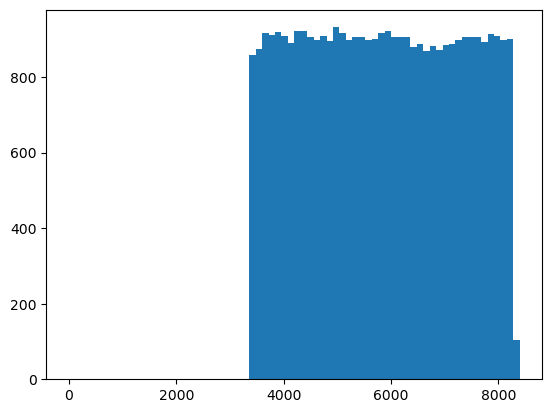

In [28]:
plt.hist(tel.SessionTime.dt.total_seconds(), bins = range(0, 8500, 120))
plt.show()
# Distribution of telemetry data seems to be close to uniform, which implies the telemetry data is complete

In [29]:
tel.isna().sum()

Date                     0
SessionTime              0
DriverAhead              0
DistanceToDriverAhead    0
Time                     0
RPM                      0
Speed                    0
nGear                    0
Throttle                 0
Brake                    0
DRS                      0
Source                   0
Distance                 0
RelativeDistance         0
Status                   0
X                        0
Y                        0
Z                        0
dtype: int64

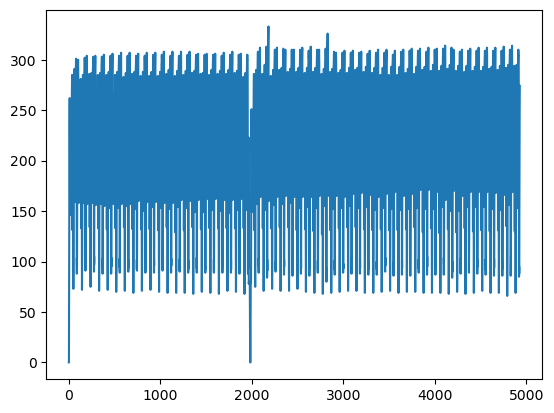

In [30]:
plt.plot(tel["Time"].dt.total_seconds(), tel["Speed"])  # Seems reasonable at a glance - Data is periodic which means laps are being driven consistently, and the 2 drops to 0 are the standing start and the pit stop

In [31]:
tel["DriverAhead"].value_counts()

DriverAhead
      25495
81     4764
12     2778
6      2543
44     1278
87      117
30       22
27       12
4        11
31       10
18       10
22        8
10        4
14        2
Name: count, dtype: int64

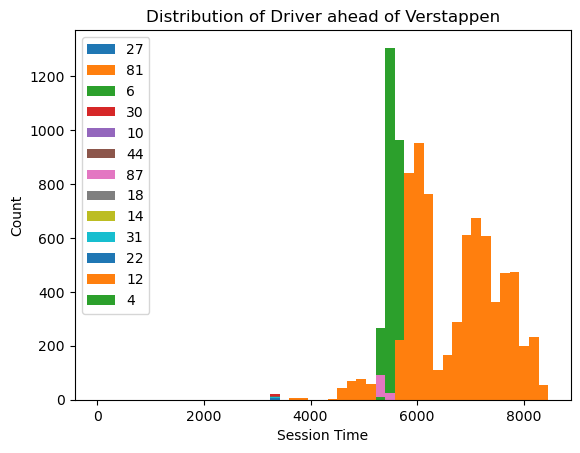

In [32]:
# Distribution of drivers that were directly ahead of Verstappen by time, having trouble verifying this data
for i in tel["DriverAhead"].unique():
    if i != "":
        specified_ahead_times = tel[tel["DriverAhead"] == i]
        plt.hist(specified_ahead_times["SessionTime"].dt.total_seconds(), label = i, bins = range(0, 8500, 180))
#plt.yscale('log')
plt.xlabel("Session Time")
plt.ylabel("Count")
plt.title("Distribution of Driver ahead of Verstappen")
plt.legend()
plt.show()

Overall, it seems that the telemetry data is complete and can be accurate if loaded properly.